# Standard Bank Tech Impact Challenge: Animal classification

The objective of this challenge is to create a machine learning model to accurately predict the likelihood that an image contains a zebra, as opposed to an elephant. While this may be an easy task for humans, elephants, and zebras, your computer will find it a bit more difficult.

The total dataset contains 13,999 images of zebras and elephants, sampled from the Snapshot Serengeti collection of more than 6 million animals.

Your task is to predict whether a given image contains a zebra or elephant. For each unique image ID in the test set you should estimate the likelihood that the image contains a zebra or elephant, with an estimated probability value between 0 and 1. A value of 1 represents a zebra and 0 represents an elephant. These images do not contain both simultaneously. It is therefore only a binary classification task.

### Dataset
You are given 13,999 photos each with a unique identifier. The data is given in jpeg format. Each photo has already been resized to 330x330 pixels.

### Importing the libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import matplotlib.image as mpimg
import seaborn as sns

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img 
from keras.preprocessing import image

from tqdm import tqdm
import tensorflow as tf
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau

## Part 1 - Loading the data

### Training, Validation and Test set individually defined

In [2]:
path_to_folder_train = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training"
image_paths = os.listdir(path_to_folder_train)
train = [path_to_folder_train+"/"+i for i in image_paths]

path_to_folder_validate = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Validation"
image_paths = os.listdir(path_to_folder_validate)
validate= [path_to_folder_validate+"/"+i for i in image_paths]

path_to_folder_test = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Testing"
image_paths = os.listdir(path_to_folder_test)
test = [path_to_folder_test+"/"+i for i in image_paths]

Below we show examples of some of the images within the Training Set.

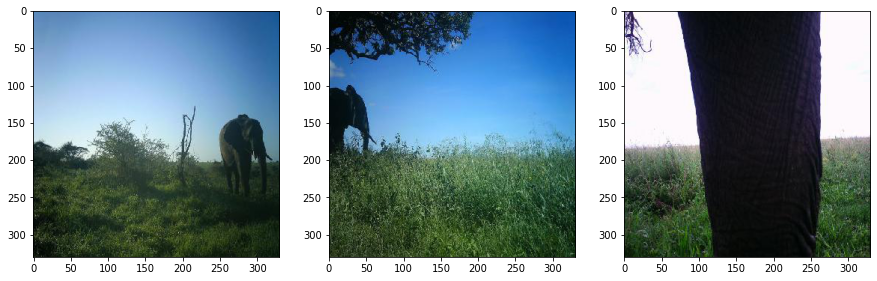

In [3]:
# Shuffling the training set images 
train_imgs = train
random.shuffle(train_imgs)
del train
gc.collect()

# Showing the images
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,ima in enumerate(train_imgs[0:3]):
    img = mpimg.imread(ima)
    imgplot = ax[i].imshow(img)
plt.show() 

We then define the target sizes (pixels) for images that will be supplied to the model - these can be changed.

The target size of 64x64 pixels was used as 32x32 pixels had a much lower test accuracy, and 128x128 pixels takes much longer to run - for only a small increase in accuracy. The batch size also denotes the size of groups of training (or later, validation and test sets, too) data that are scaled at a time. Two sizes were evaluated: 32 and 64, of which a batch size of 32 images has a higher test accuracy. This value is used.

In [4]:
nrows = 64
ncolums = 64 
batch_size = 32
channels = 3 # The channel denotes that the images are read as colour images, not greyscale.

Below are user-defined functions for retrieving the images, converting them to the target size as defined above, and reading through a given list of images.

In [5]:
def get_image_x(image):
    return cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR) , (nrows, ncolums) , interpolation = cv2.INTER_CUBIC)
    
def read_and_process_image(list_of_images):
    x = []
    y = []
    for image in tqdm(list_of_images):
        try:
            x.append(get_image_x(image))
        except:
            print("An image caused a probelem",image)
            continue
        if "elephant" in image:
            y.append(0)
        else:
            y.append(1)   
    return x,y

Now we explicitly create the input and target variables for our Training, Validation and Test set, using the above-mentioned function(s).

 60%|█████▉    | 5950/10000 [00:20<00:14, 277.21it/s]

An image caused a probelem /Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training/IMG10288_zebra.jpeg


100%|██████████| 10000/10000 [00:33<00:00, 296.28it/s]
/Users/tomashegewisch/lunch_lab_project_final/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


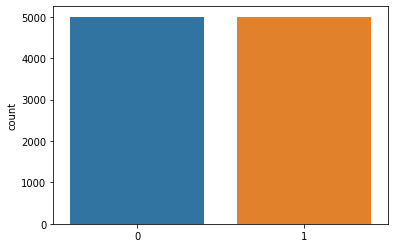

In [6]:
X, y = read_and_process_image(train_imgs)
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)

sns.countplot(y_train)
plt.show()

Above you can see that the training set carries 10 000 images in total: half of which identify as elephants, and the other half as zebras. Now, we shall do the same generation of the validation and test set input and target variables, and display the shapes of each input or target variable.

In [7]:
X_val, y_val = read_and_process_image(validate)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test, y_test = read_and_process_image(test)
X_test = np.array(X_test)
y_test = np.array(y_test)

del validate
del test
gc.collect()

100%|██████████| 2000/2000 [00:06<00:00, 298.97it/s]


2361

In [8]:
print("The shape of X_train:",X_train.shape)
print("The shape of X_val:", X_val.shape)
print("The shape of y_train:",y_train.shape)
print("The shape of y_val:", y_val.shape)
print("The shape of X_test:",X_test.shape)
print("The shape of y_test:", y_test.shape)

The shape of X_train: (9999, 64, 64, 3)
The shape of X_val: (2000, 64, 64, 3)
The shape of y_train: (9999,)
The shape of y_val: (2000,)
The shape of X_test: (2000, 64, 64, 3)
The shape of y_test: (2000,)


## Part 2 - Data Augmentation & Preprocessing

### Example of Data Augmentation

Data augmentation is an essential way to fight overfitting for computer vision models. It is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. 

This is helpful in instances where the training set size is deemed not large enough, or when the model requires variations of the images that it learns from, so it can improve the ability and robustness of the fit models to generalize what they have learned to new images. These new images could be supplied in more warped variations from the images the model learns off, and this variation in images supplied to the model to train on builds this robustness.

Training deep learning neural network models on more data can also result in more skillful models. In order to make the most of our training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice.

Here I have created an instance of the ImageDataGenerator module to illustrate the capabilities of the augmentationt transformations on the image dataset.

In [9]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Above you will find a few of the options available for augmenting the images in your dataset with ImageDataGenerator.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

#### Now we import a single image and showcase the results of various augmentation techniques:

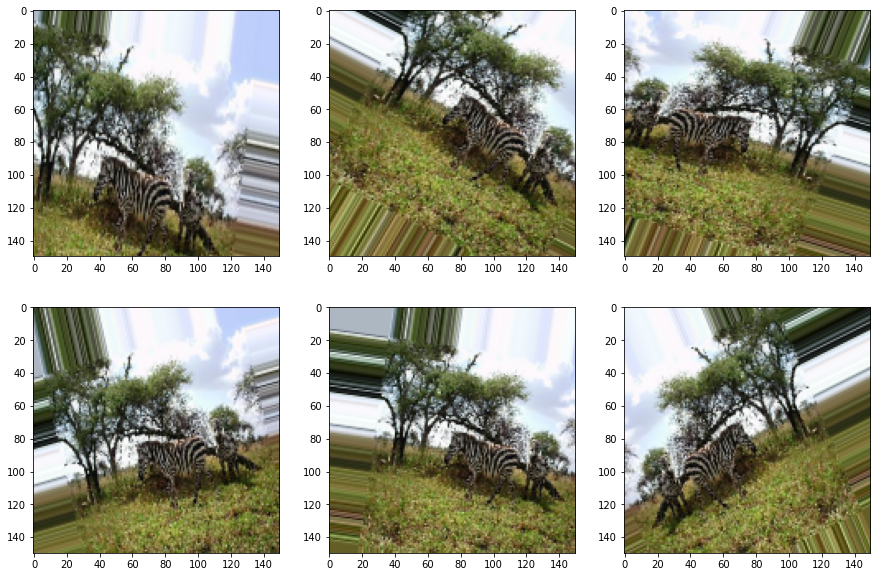

In [127]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import os

base_dir = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab"
direc = os.path.join(base_dir, 'Training')
elephants = os.listdir(direc)

img_path = os.path.join(direc, elephants[23])

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

fig, ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.flatten()

# The .flow() command below generates batches of randomly transformed images. It loops indefinitely, so we need to include a `break` the loop.
i = 0
for batch in datagen.flow(x, batch_size=1):
    ax[i].imshow(array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break

The images generated showcase the manner in which the augmentation occurs, by few of the techniques given in the datagen instance above for ImageDataGenerator. This shows how the images change upon augmentation and how the model comes to learn off these. Now we will preprocess and augment the training, validation and test sets, properly. 

### Preprocessing the Training set

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

training_set =  train_datagen.flow(X_train, y_train, batch_size = batch_size)

The ImageDataGenerator class can be used to rescale pixel values from the range of 0-255 to the range 0-1 (by dividing by 255) which is preferred for neural network models. This would act to normalize the data for the model. Without any further preprocessing, by means of standardization or normalization, the Test Accuracy was initially very high.

The data, however, can be centred/standardised further, in a featurewise or samplewise manner (i.e., overall for the training set, or per image), which may be beneficial when training neural networks, especially with standardization as the dataset sums to zero and the inputs are small values in the rough range of about -3.0 to 3.0 (e.g. 99.7 of the values will fall within three standard deviations of the mean).

Therefore, normalization and standardization techniques were both tested and evaluated. However, there was little change induced by either technique. Of the few changes noticed, the featurewise standardization ("featurewise_center=True, featurewise_std_normalization=True") showed the best change, but for simplicity, was omitted from the preprocessing of the data, as it caused other issues with training the data which we felt was not overcome by the small increase in efficiency. Thus, scaling showed sufficient preprocessing together with the augmentation.

### Preprocessing the Validation set

In [12]:
valid_datagen = ImageDataGenerator(rescale=1./255)

validation_set = valid_datagen.flow(X_val, y_val, batch_size= batch_size)

### Preprocessing the Test set

In [113]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow(X_test, y_test, batch_size= batch_size, shuffle = False)

## Part 2 - Choosing Model & Building It

### Choosing the model:
The model chosen was a structured neural network, specifically, a convolutional neural network (CNN). CNNs are fully connected, forward neural networks. They are effective in reducing the number of parameters/dimension by filtering, pooling and flattening the data, without losing on the quality of models. Images have high dimensionality (as each pixel is considered as a feature) which suits the above described abilities of CNNs. Also, CNNs were developed keeping images into consideration and are trained to identify the edges of objects in any image.

All the layers of a CNN have multiple convolutional filters which work and scan the complete feature matrix (of the input data) and carry out the dimensionality reduction. This enables CNN to be a very apt and fit network for image classifications and processing. For this reason, as a group we opted for the CNN model to perform the given task - and we adapted the model into two variations: one with only two layers, without a dropout layer, and the other with five layers, one of which being a dropout layer. This showed the value in not only more convolutional layers being either better or worse than less, but also whether a dropout layer could sufficiently benefit the model training.

The second model was proven to be much better, on the final test accuracy. Although results of the previous model were not stored, the code building the first CNN is given below, and literature/research does support more convolutional layers to have a better skilled model, and including a dropout layer.

The main advantage of a dropout layer is that it prevents all neurons in a layer from synchronously optimizing their weights. This adaptation, made randomly, prevents all the neurons from converging to the same goal, thus decorrelating the weights.

## First Model: 2-Layered CNN, without Dropout layer

In [14]:
# cnn = tf.keras.models.Sequential()
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# cnn.add(tf.keras.layers.Flatten())
# cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
# cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# cnn.summary()

## Second Model: 4-Layered CNN, with Dropout layer

In [15]:
# Initialising the CNN
cnn = models.Sequential()

# Step 1 - Convolution
cnn.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(64, 64, 3)))

# Step 2 - Pooling
cnn.add(layers.MaxPooling2D ((2, 2)))

# Step 3 - Adding another three convolutional layers
cnn.add(layers.Conv2D(64, (3,3), activation = "relu")) # 1
cnn.add(layers.MaxPooling2D ((2,2)))
cnn.add(layers.Conv2D(128, (3,3), activation = "relu")) # 2
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(256, (3,3), activation = "relu")) # 3
cnn.add(layers.MaxPooling2D((2,2)))

# Step 4 - Flattening
cnn.add(layers.Flatten())

# Step 5 - Dropout Layer
cnn.add(layers.Dropout(0.5)) # Dropot of regularisation

# Step 6 - Fully Connected Layer
cnn.add(layers.Dense(512, activation = "relu"))

# Step 7 - Output Layer
cnn.add(layers.Dense(1, activation = 'sigmoid'))

# Print summary of CNN layers & network
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

## Part 3 - Model Training

### Compiling the Model

The learning rate is considered an important hyperparameter when configuring the neural network. The learning rate manages how quickly the model adapts to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights upon each update, whereas larger learning rates result in rapid changes and require fewer epochs. A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas too small a learning rate can cause the process to get stuck.

For this reason, the callback function, ReduceLROnPlateau(), is used, which changes the learning rate once the model stops training properly. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.

In [16]:
optimmizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

cnn.compile(optimizer=optimmizer, loss='binary_crossentropy', metrics=['accuracy'])

For understanding on the parameters in the optimizer, see their explanations below:
- beta1: The exponential decay rate for the first moment estimates (e.g. 0.9).
- beta2: The exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).
- epsilon. Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8).

### Training the Model on the Training set and evaluating it on the Validation set.

EarlyStopping() is a callback function, used as a means of tuning the hyperparameter: number of epochs. It is discussed in more detail under Model Tuning. This function, along with ReduceLROnPlateau(), seek to find the best performing parameters for the training of convolutional neural network.

In [17]:
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy",  
                                        mode ="max", patience = 8,  
                                        restore_best_weights = True) 
history = cnn.fit(training_set, 
                  validation_data = validation_set, 
                  epochs = 65, callbacks=[earlystopping,rlrop])

Epoch 1/65
313/313 [==============================] - 102s 322ms/step - loss: 0.5431 - accuracy: 0.6993 - val_loss: 0.3210 - val_accuracy: 0.8615
Epoch 2/65
313/313 [==============================] - 102s 325ms/step - loss: 0.3386 - accuracy: 0.8521 - val_loss: 0.2643 - val_accuracy: 0.8910
Epoch 3/65
313/313 [==============================] - 105s 335ms/step - loss: 0.2626 - accuracy: 0.8920 - val_loss: 0.3043 - val_accuracy: 0.8860
Epoch 4/65
313/313 [==============================] - 108s 347ms/step - loss: 0.2321 - accuracy: 0.9058 - val_loss: 0.1740 - val_accuracy: 0.9330
Epoch 5/65
313/313 [==============================] - 107s 342ms/step - loss: 0.2192 - accuracy: 0.9147 - val_loss: 0.1672 - val_accuracy: 0.9395
Epoch 6/65
313/313 [==============================] - 101s 322ms/step - loss: 0.1832 - accuracy: 0.9244 - val_loss: 0.1516 - val_accuracy: 0.9395
Epoch 7/65
313/313 [==============================] - 95s 304ms/step - loss: 0.1693 - accuracy: 0.9364 - val_loss: 0.1577 - 

## Part 4 - Model Tuning

- The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. This parameter needs to be optimised. This was done by using a callback method (EarlyStopping()) to halt the process once the validation loss reaches a minimum - and checks it by continuing 8 more epochs afterwards - which allows us to view the optimum number of epochs to use for the model so as to prevent overfitting. For a total of 65 epochs used in the last trial run, an optimal number of 29 epochs was discovered.


- The learning rate, tuned by ReduceLROnPlateau(), is not explicitly outputed to us to see its final value, however it is tuned throughout the training of the model.


- optimizer in the compile() method was evaluated for the best method. Adam is noted to be one of the best optimizer methods, and RMSProp is also dually noted across various articles. For the sake of this project, two optimizers were evaluated: 'adam' and 'rmsprop'. Adam did in fact work out to be better, and is supported by literature to be an appropriate method for problems with very noisy/or sparse gradients; also, instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance). Adam is a popular algorithm in the field of deep learning because it achieves good results fast and that is why it was chosen as the optimizer function.


- for the loss function, the 'binary crossentropy' function is used as it noted widely to be intended for use with binary classification tasks, where the target values are in the set {0, 1}. To be specific, cross entropy is equivalent to fitting the model with maximum likelihood estimation - which minimises dissimilarity between the training data empirical distribution and the model's induced distribution. These estimators have good asymptomatic properties and are consistent, as well as being statistically significant. This cross-entropy function gives well-calibrated probabilities.

## Part 5 - Model Evaluation/Performance

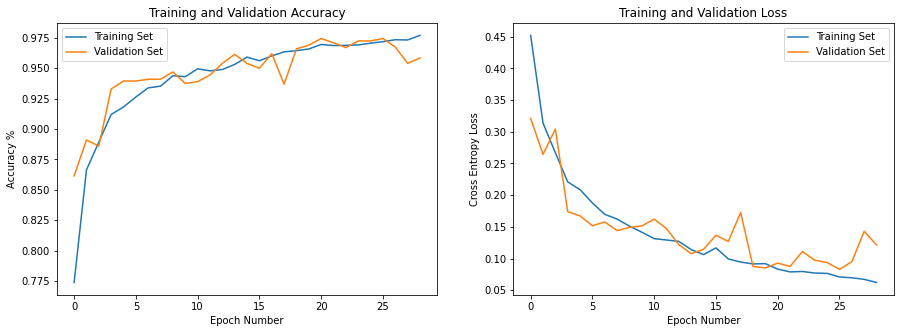

<Figure size 432x288 with 0 Axes>

In [26]:
# Retrieve a list of accuracy results on training and validation data sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1,2,figsize=(15,5))

# Plot training and validation accuracy per epoch
ax[0].plot(epochs, acc, label='Training Set')
ax[0].plot(epochs, val_acc, label='Validation Set')
ax[0].legend()
ax[0].set_xlabel('Epoch Number')
ax[0].set_ylabel('Accuracy %')
ax[0].title.set_text('Training and Validation Accuracy')
plt.figure()

# Plot training and validation loss per epoch
ax[1].plot(epochs, loss, label='Training Set')
ax[1].plot(epochs, val_loss, label='Validation Set')
ax[1].legend()
ax[1].set_xlabel('Epoch Number')
ax[1].set_ylabel('Cross Entropy Loss')
ax[1].title.set_text('Training and Validation Loss')
plt.show()

### Discussion of Training set versus Validation set results
The first thing to note is that we’re not overfitting as the train and validation accuracy are pretty close and following each other. We can also notice that the accuracy keeps increasing as the epoch increases, giving us the intuition that increasing the epoch size will likely give us a higher accuracy/ lower loss. 

Specifically looking at the accuracy graph, training and validation set accuracies follow similar trends, where the one tends to increase along with the other. However, the graph shows the volatility of the validation set to result in must greater changes to its accuracy, for a small change in training set accuracy. The jumps for the validation set are much more severe. 

The accuracy model does not show major overfitting to the training set, but the loss graph does in few instances. Similarly to the accuracy graph, the loss graph shows the validation set being very sensitive to movements in the training loss. It also shows at more than one epoch that for a decrease in training set loss, there is an increase in validation set loss. This means there are instances where the model experiences overfitting, and this may cause inaccuracies for the test set further on in the model assessment. However, both datasets' accuracies remain very high, and their losses low, and within very close precision to one another's values. It can thus be said that the model quite accurately predicts the zebras or elephants from images, as validated by the validation set scores, and that the model performs well with the above-mentioned parameters and tuning.

## Part 6: Test Set Performance

In [81]:
loss, acc = cnn.evaluate(test_set, steps=len(test_set), verbose=0, batch_size=batch_size)
print('Test Accuracy: %.2f' % (acc * 100))
print('Test loss: %.2f' % (loss))

Test Accuracy: 98.05
Test loss: 0.06
train Accuracy: 97.45
train loss: 0.09


With a confusion matrix, we can see the results as they are described per category, for the Test set. This will help us understand where the model incorrectly predicts, or what is the most 'likely false prediction' that we can expect. For such a high accuracy to begin with, the false predictions are expected to be low, but this will show us where and when false predictions do occur.

63/63 [==============================] - 5s 81ms/step
Confusion Matrix


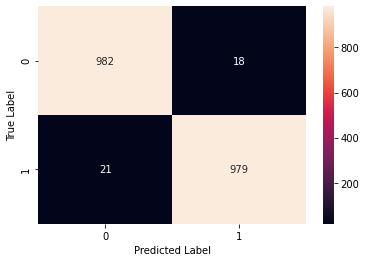

[[982  18]
 [ 21 979]]


In [118]:
from sklearn.metrics import confusion_matrix

Y_pred = cnn.predict(test_set, steps=len(test_set),batch_size=batch_size, verbose=1)
# Y_pred = cnn.predict(test_set)
Y_pred = np.array(Y_pred).round()

print('Confusion Matrix')
conf = (confusion_matrix(y_test, Y_pred))
y = ['0', '1']
sns.heatmap(conf,annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(conf)

### Discussion on Test set results
The test set shows an almost perfect set of results for binary image classification. The few instances of incorrect predictions show that more inaccuracies are caused by predicting zebras as elephants (False negatives), as opposed to the fewer counts of incorrectly predicting an elephant as a zebra (False positives). The confusion matrix above, however, does support the high accuracies of the test set, and it validates our trust in the model to perform well on a new set of images. 

## Part 7 - Visualising the Results

As an extra precautionary step of visualing our results on the test set, this random image generator feeds test set images to the model and allows us to visualise which images it (potentially) gets wrong. Thus, for further better of the model performance, and perhaps more insight into the details and specifics of data augmentation and preprocessing, the model could learn better off images/ instances that it struggles with. The issues in the set below merely show that the model may struggle with images that show animals much further away (or very small in the image) or when there does not seem to be an animal in the photo - then its possibly unsure. However, for the naked eye, none of the images below record clearly incorrect predictions, which is ideally what the model should do, and thus it does exactly that, well!

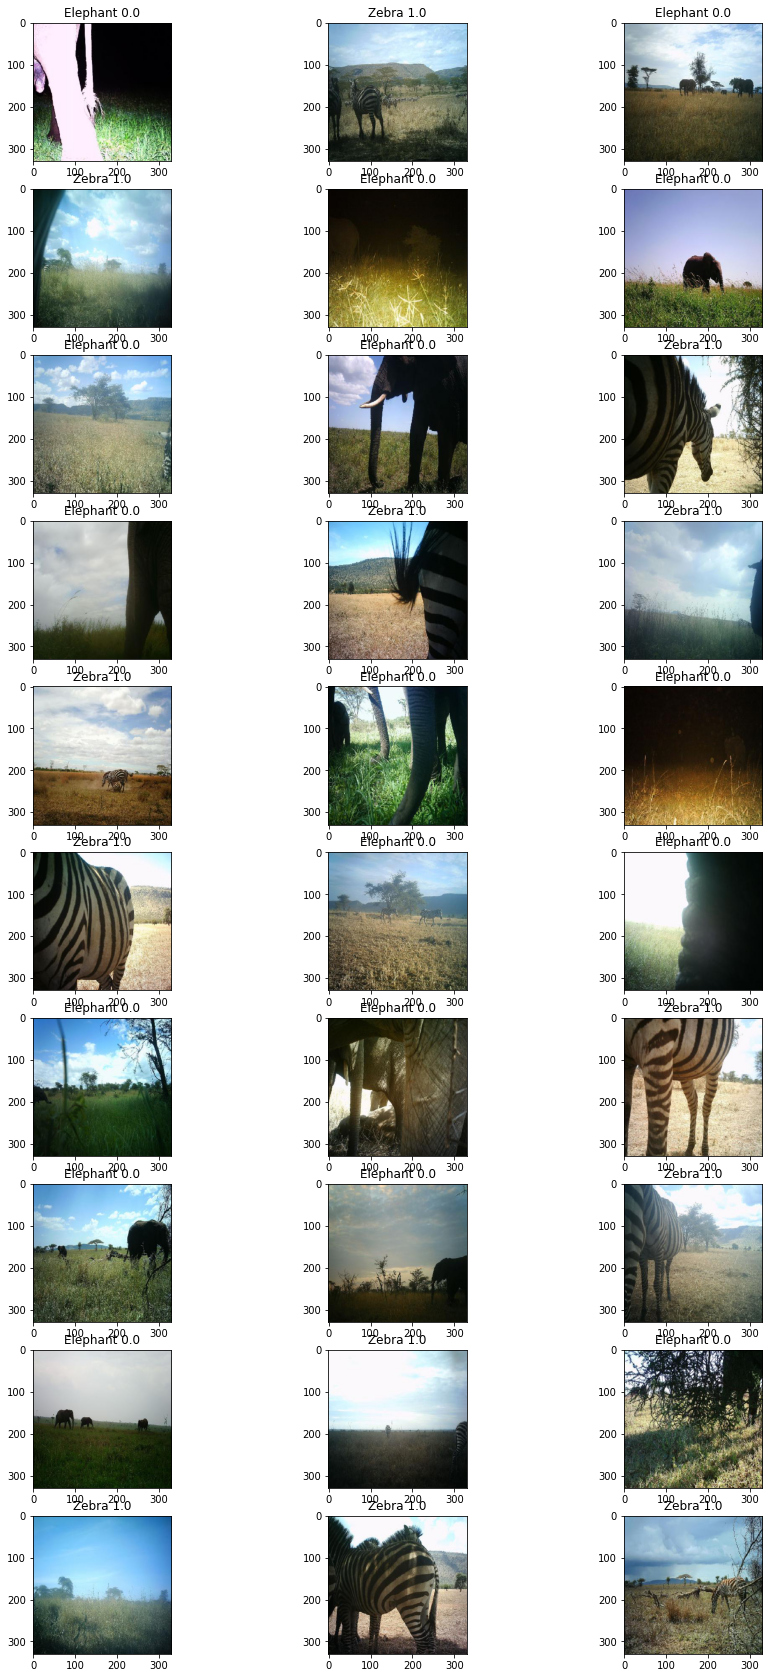

In [54]:
fig, ax = plt.subplots(10,3,figsize=(15,30))
ax = ax.flatten()
for i in range(0,30):
    path_to_folder = '/Users/tomashegewisch/Downloads/data_set/test/'
    path_to_folder = '/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Testing/'
#     path_to_folder = '/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training/'

    image_paths = os.listdir(path_to_folder)
    file = np.random.choice(image_paths)
    path_to_test_image = path_to_folder + file
    
    x = np.array([get_image_x(path_to_test_image)])
    result = cnn.predict(x)

    if result[0][0] == 1:
        prediction = 'Zebra'
    else:
        prediction = 'Elephant'
    img = mpimg.imread(path_to_test_image)
    ax[i].imshow(img)
    ax[i].title.set_text(prediction+" "+str(result[0][0]))
plt.show()

In [119]:
cnn.save_weights('model_weights.h5')
cnn.save('model_keras.h5')